In [1]:
import numpy as np
import cv2
from sklearn import svm
import matplotlib.pyplot as plt
import glob
import pickle
import os

In [12]:
# data load for hw7 images
folder_train = '/home/xingguang/Documents/ECE661/hw7/images/training'
folder_test = '/home/xingguang/Documents/ECE661/hw7/images/testing'
classes = ['beach', 'building', 'car', 'mountain', 'tree']
train_val_images = {'beach':[], 'building':[], 'car':[], 'mountain':[], 'tree':[]}
test_images = {'beach':[], 'building':[], 'car':[], 'mountain':[], 'tree':[]}
for c in classes:
    for i in range(1, 21):
        img_path = os.path.join(folder_train, c, '{0:02d}.jpg'.format(i))
        img = cv2.imread(img_path)
        try:
            s = img.shape
        except AttributeError:
            print(img_path)
        train_val_images[c].append(img)
    for i in range(1, 6):
        img_path = os.path.join(folder_test, c + '_' + str(i) +'.jpg')
        test_images[c].append(cv2.imread(img_path))

In [2]:
# data load for hw8 images
folder_train = 'images/training/'
folder_test = 'images/testing/'
classes = ['cloudy', 'rain', 'shine', 'sunrise']
train_val_images = {'cloudy':[], 'rain':[], 'shine':[], 'sunrise':[]}
test_images = {'cloudy':[], 'rain':[], 'shine':[], 'sunrise':[]}
for c in classes:
    name_list_train = glob.glob(folder_train + c + "*.jpg")
    name_list_test = glob.glob(folder_test + c + "*.jpg")
    for f in name_list_train:
        img = cv2.imread(f)
        try:
            s = img.shape
        except AttributeError:
            print(f)
        train_val_images[c].append(img)
    for f in name_list_test:
        test_images[c].append(cv2.imread(f))
    print(len(train_val_images[c]))

290
203
243
346


In [3]:
def gram(data_dict, kernel, resized=16, normalize=False):
    channel = kernel.shape[0]
    kernel_size = kernel.shape[1]
    classes = list(data_dict.keys())
    iu = np.triu_indices(channel)
    data = []
    label = []
    for label_idx, c in enumerate(classes):
        for img in data_dict[c]:
            feature_img = np.zeros((channel, resized*resized*3))
            if normalize:
                feature_img = feature_img / np.linalg.norm(feature_img)
            for i in range(channel):
                filtered = cv2.resize(cv2.filter2D(img,-1,kernel[i]), (resized, resized))
                feature_img[i,:] = filtered.reshape((1, -1))
            gram = np.dot(feature_img, feature_img.T)
            data.append(gram[iu].reshape((1, -1)))
            label.append(label_idx)
    data_vec = np.concatenate(data, axis=0)
    label_vec = np.array(label)
    return data_vec, label_vec

def split_data(data, label, train_ratio=0.75):
    num = data.shape[0]
    pidx = np.random.permutation(num)
    train_num = int(num * train_ratio)
    train_idx = pidx[:train_num]
    valid_idx = pidx[train_num:]
    train_data = data[train_idx]
    valid_data = data[valid_idx]
    train_label = label[train_idx]
    valid_label = label[valid_idx]
    return train_data, train_label, valid_data, valid_label


def train(data, kernel_size, channel, resized, train_ratio, train_steps):
    clf = svm.SVC(kernel='poly')
    acc_list = []
    kernel_list = []
    for n in range(train_steps):
        kernel = np.random.uniform(-1, 1, size=(channel, kernel_size, kernel_size))
        train_val_vecs, train_val_label = gram(data, kernel, resized)
        train_data, train_label, valid_data, valid_label = split_data(train_val_vecs, train_val_label, train_ratio)
        clf.fit(train_data, train_label)
        predicted = clf.predict(valid_data)
        acc = np.sum(predicted==valid_label) / valid_label.shape[0]
        print(n, acc)
        acc_list.append(acc)
        kernel_list.append(kernel)
    acc_avg = np.sum(acc_list) / len(acc_list)
    best_idx = np.argmax(acc_list)
    print("acc_avg:", acc_avg, "best_idx:", best_idx)
    return kernel_list[best_idx]

In [4]:
def make_confusion_matrix(predicted, gt, class_num=4):
    cm = np.zeros((class_num, class_num))
    for i in range(class_num):
        idx_class_i = np.where(gt == i)
        predicted_part = predicted[idx_class_i]
        for j in range(class_num):
            cm[i, j] = np.sum(predicted_part == j)
    return cm

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [36]:
kernel_size = 7
channel = 16
resized = 16
train_ratio = 0.75
train_steps = 10

In [37]:
kernel = train(train_val_images, kernel_size, channel, resized, train_ratio, train_steps)

0 0.5977859778597786
1 0.5719557195571956
2 0.5793357933579336
3 0.6420664206642066
4 0.5719557195571956
5 0.6125461254612546
6 0.6236162361623616
7 0.43911439114391143
8 0.5830258302583026
9 0.5645756457564576
acc_avg: 0.5785977859778597 best_idx: 3


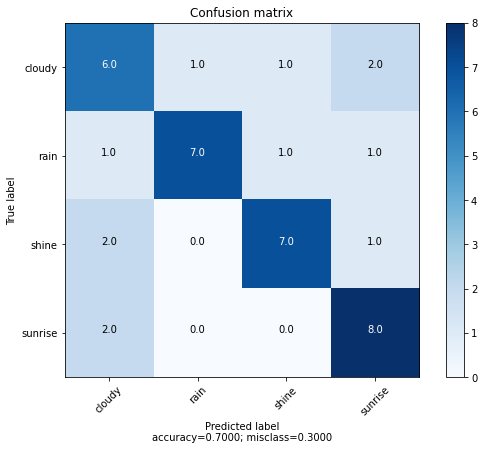

In [41]:
train_vecs, train_label = gram(train_val_images, kernel, resized)
test_data, test_label = gram(test_images, kernel, resized)
clf = svm.SVC(kernel='poly')
clf.fit(train_vecs, train_label)
predicted = clf.predict(test_data)
confusion_matrix = make_confusion_matrix(predicted, test_label, 4)
plot_confusion_matrix(confusion_matrix,
                          target_names=classes,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [148]:
# save model and kernel
with open('best_svm_k9.pkl', 'wb') as handle:
    pickle.dump(clf, handle)
np.save('best_kernel_k9.npy', kernel)

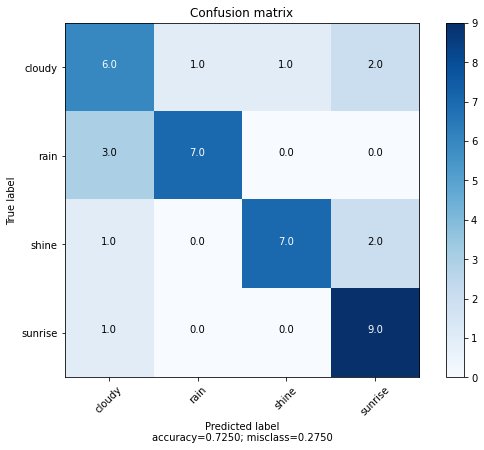

In [39]:
# reproduce the result
def reproduce(test_images, kernel_path='best_kernel.npy', svm_path='best_svm.pkl'):
    resized = 16
    kernel = np.load(kernel_path)
    clf = pickle.load(open(svm_path, 'rb'))
    # train_vecs, train_label = gram(train_val_images, kernel, resized)
    test_data, test_label = gram(test_images, kernel, resized)
    # clf.fit(train_vecs, train_label)
    predicted = clf.predict(test_data)
    confusion_matrix = make_confusion_matrix(predicted, test_label, 4)
    plot_confusion_matrix(confusion_matrix,
                            target_names=classes,
                            title='Confusion matrix',
                            cmap=None,
                            normalize=False)
reproduce(test_images)

In [ ]:
# para:
# kernel_size = 7
# channel = 8, 16, 32
# resized = 16
# train_ratio = 0.75
# acc_avg = 0.553, 0.589, 0.579
# result = 0.575, 0.725, 0.700


# kernel_size = 5
# channel = 8, 16, 32
# resized = 16
# train_ratio = 0.75
# train_steps = 20
# avg acc: 0.518, 0.558, 0.557
# result = 0.525, 0.550, 0.625


# kernel_size = 3
# channel = 8, 16, 32
# resized = 16
# train_ratio = 0.75
# train_steps = 20
# avg acc: 0.498, 0.558, 0.565
# result = 0.500, 0.550, 0.525

# kernel_size = 9
# channel = 8, 16, 32
# resized = 16
# train_ratio = 0.75
# train_steps = 20
# avg acc: 0.513, 0.590, 0.615
# result = 0.550, 0.600, 0.625